## GEOSeMOSYS - exploring linear programming geospatial energy modelling 

Nandi Moksnes, Mark Howells, Will Usher

This Jupyter Notebook is both a description of how to reproduce the results in the paper and where you run the code.
For any questions please contact Nandi Moksnes: nandi@kth.se

## 1. The files in "input_data/GIS_data" are downloaded and placed in a "temp" folder.
Approx 25 min

### Datasets
[Nighttimelight data average masked, 2020](https://eogdata.mines.edu/nighttime_light/annual/v20/2020/VNL_v2_npp_2020_global_vcmslcfg_c202102150000.average_masked.tif.gz)
[GDP_PPP_2015_WGS_84](https://zenodo.org/record/4736323/files/GDP_PPP_Layer2015.tif?download=1)
[ADM: gadm36_KEN_shp](https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_KEN_shp.zip,gadm36_KEN_shp.zip)
[Roads](https://energydata.info/dataset/b71146ac-0330-40f5-bd47-e0d20a761e48/resource/caf4f528-e982-4db8-811c-fdbf5322352f/download/roads.zip)
[11kV transmission Kenya](https://energydata.info/dataset/43e26a70-66be-419d-8fd0-5ed53fa98fd5/resource/ce311dec-c757-42da-86b8-de58160627e0/download/transmission-lines-11kv.zip)
[33kV transmission Kenya.zip](https://energydata.info/dataset/43e26a70-66be-419d-8fd0-5ed53fa98fd5/resource/28c470ef-a34f-4010-82e5-c743e5e395a1/download/transmission-lines-33kv.zip)
[66kV transmission Kenya](https://energydata.info/dataset/43e26a70-66be-419d-8fd0-5ed53fa98fd5/resource/bf437ae3-866b-4229-9234-06e04c30368a/download/transmission-lines-66kv.zip)
[132kV transmission Kenya](https://energydata.info/dataset/43e26a70-66be-419d-8fd0-5ed53fa98fd5/resource/4dfbd761-8961-49d4-a76d-e2ad6bc03ee7/download/transmission-lines-132kv.zip)
[220kV transmission Kenya](https://energydata.info/dataset/43e26a70-66be-419d-8fd0-5ed53fa98fd5/resource/39c0185d-3c46-4d25-87d9-39e357a7aaea/download/transmission-lines-220kv.zip)
[mini-grid-exisitng.zip](https://energydata.info/dataset/8f3c4f8f-ec01-4eda-b14b-3ae58319ac41/resource/3fe41c27-5428-4f26-9279-63d7d5c632be/download/existing-mini-grids.zip)
[minigrid-under-development](https://energydata.info/dataset/8f3c4f8f-ec01-4eda-b14b-3ae58319ac41/resource/a347eacb-e1de-4c95-8a65-8619fc100a83/download/mini-grids-under-development.zip)
[transformersKenya](https://energydata.info/dataset/84ca7288-1d10-469d-a98d-26643f869367/resource/69216202-4b3b-459f-9d16-1e9f15a4f6d5/download/distribution-transformer.zip)
[transmissionstationsKenya](https://energydata.info/dataset/d163a91c-b626-46c2-9fd3-c51df551a844/resource/254cf187-7cdf-4539-8021-2280342b92a7/download/transmission-stations.zip)
[primary-substationsKenya](https://energydata.info/dataset/6882b9c0-85e2-42a0-aa56-44128f549b42/resource/95818e94-d01a-445a-95d7-b46f2cc1d637/download/primary-substations.zip)

In [ ]:
%load_ext autoreload
%autoreload
from datetime import datetime

date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

from Download_files import *
import os

URL_viirs = 'https://eogdata.mines.edu/nighttime_light/annual/v20/2020/VNL_v2_npp_2020_global_vcmslcfg_c202102150000.average_masked.tif.gz'
    
download_url_data('input_data/GIS_URL.txt', 'temp')
download_viirs(URL_viirs, 'temp')
unzip_all('input_data/GIS_unzip.txt', '../GIS_data')

## 2. The files are then projected and clipped to the administrative boundaries. 
Approx 3 hours

In [ ]:
%autoreload
from datetime import datetime
date = datetime. now(). strftime("%Y_%m_%d-%I:%M:%S_%p")
print(date)

import os
from Project_GIS import *


project_main('../GIS_data', '../Projected_files')

## 3. Through QGIS make raster to point layer and save (MANUAL STEP)

From this layer: [Population Kenya: High Resolution Population Density Maps, for 2019](https://data.humdata.org/dataset/2964b369-c10c-4b55-94a8-495de3fc9858/resource/1271b53b-30be-4c4b-aa27-1bd104506636/download/ken_general_2020_geotiff.zip) 
1) Reproject the HRSL to CRS EPSG:32737 - WGS 84 / UTM zone 37S - Projected
2) Reduce the resolution through GRASS "r.resamp.stats" with cellsize 1000 m.
3) Remove values under 1 with Raster calculator.
4) Then run SAGA: raster to point in QGIS

This step is downloaded from zenodo so it is not needed for the user to execute.

Run time: Approx 1 minute


In [5]:
%load_ext autoreload
%autoreload

from datetime import datetime
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

from Download_files import *
import os
#Make sure you are in the /src directory when you start this script
print(os.getcwd())

download_url_data("input_data/zenodo.txt", "Projected_files")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022 01 12-12:46:28_PM
C:\Users\sebas\Desktop\GEOSeMOSYS_Kenya-master (2)\GEOSeMOSYS_Kenya-master\src


()

## 4. The GIS layers are prepared to for a heuristic approximation for electrified settlements
Approx 15 min

In [6]:
%autoreload
import matplotlib.pyplot as plt
from settlement_build import *

date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

#Make sure you are in the /src directory when you start this script
print(os.getcwd())

pop_shp = '../Projected_files/raster_to_point_UMT37S_Kenya.shp'
Projected_files_path = '../Projected_files'

rasterize = raster_proximity(Projected_files_path)
points = raster_to_point(rasterize, pop_shp, Projected_files_path)

2022 01 12-12:46:56_PM
C:\Users\sebas\Desktop\GEOSeMOSYS_Kenya-master (2)\GEOSeMOSYS_Kenya-master\src
Rasterizing ../Projected_files\Concat_Transmission_lines_UMT37S.shp
Rasterizing ../Projected_files\UMT37S_Primary_Substations.shp
Rasterizing ../Projected_files\UMT37S_Distribution_Transformers.shp
Rasterizing ../Projected_files\Concat_Mini-grid_UMT37S.shp
Rasterizing ../Projected_files\UMT37S_Roads.shp
Rasterizing ../Projected_files\Concat_MV_lines_UMT37S.shp
Rasterizing ../Projected_files\UMT37S_11kV.shp
Making proximity analysis ../Projected_files\Concat_Transmission_lines_UMT37S.tif
Making proximity analysis ../Projected_files\UMT37S_Primary_Substations.tif
Making proximity analysis ../Projected_files\UMT37S_Distribution_Transformers.tif
Making proximity analysis ../Projected_files\Concat_Mini-grid_UMT37S.tif
Making proximity analysis ../Projected_files\UMT37S_Roads.tif
Making proximity analysis ../Projected_files\Concat_MV_lines_UMT37S.tif
Making proximity analysis ../Projected_fi

C:\Users\sebas\Desktop\GEOSeMOSYS_Kenya-master (2)\GEOSeMOSYS_Kenya-master\src\settlement_build.py:121: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  settlements.to_file(os.path.join(proj_path, 'settlements.shp'))


The dataframe is saved to settlements.shp


## 5. Approximate location of urban settlements and the electrified settlements 1kmx1km resolution
Approx 10 min. Make sure to wait so that the shapefile and csv file is saved properly from step 4.

In [7]:
%autoreload
from elec_start import *
import os

date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

elec_actual = 0.697  # percent #https://data.worldbank.org/indicator/EG.ELC.ACCS.ZS accessed 2021-10-02
pop_cutoff = 4000  # people
dist_minigrid = 3000  # meters
dist_mv = 1000 #meters
dist_lv = 1000 #meters
dist_to_trans = 500  # meters
dist_to_sub = 1000 #meters
dist_minig = 1000 #meters
min_night_lights = 0.5
max_grid_dist = 5000  # meters
max_road_dist = 500  # meters
pop_cutoff2 = 36000 # people
urban_elec_ratio = 90.8  # percent https://data.worldbank.org/indicator/EG.ELC.ACCS.UR.ZS accessed 2021-10-02
rural_elec_ratio = 61.7  # percent https://data.worldbank.org/indicator/EG.ELC.ACCS.RU.ZS accessed 2021-10-02
pop_actual = 53771300  # people https://data.worldbank.org/indicator/SP.POP.TOTL?locations=KE accessed 2021-10-02
urban = 0.28  # percent https://data.worldbank.org/indicator/SP.URB.TOTL.IN.ZS?locations=KE accessed 2021-10-02
urban_cutoff = 20000
start_year = 2019
settlement = gpd.read_file("../Projected_files/settlements.shp")

settlements = pd.DataFrame(settlement, copy=True)
urbansettlements = calibrate_pop_and_urban(settlements, pop_actual, urban, urban_cutoff)
elec_current_and_future(urbansettlements, elec_actual, pop_cutoff, dist_to_trans, dist_to_sub, dist_minig, min_night_lights,
                            max_grid_dist, urban_elec_ratio, rural_elec_ratio, max_road_dist, pop_actual, pop_cutoff2, start_year, dist_mv, dist_lv)


2022 01 12-12:49:12_PM
Calibrate current population
Calibrate urban split
Calibrate current electrification
0.6934715313748702
The modelled electrification rate achieved is 0.6934715313748702. If this is not acceptable please revise this part of the algorithm
(All units are in meters):  Nightlight (avg rad): 0.5 Transformers: 500 Substations: 1000 Distance to HV: 5000 Road 500 Elec percent: 0.6934715313748702 Population threshold: 4000 Distance to mini grid: 1000 Distance to MV: 1000 Distance to LV: 1000


C:\Users\sebas\Desktop\GEOSeMOSYS_Kenya-master (2)\GEOSeMOSYS_Kenya-master\src\elec_start.py:239: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("../Projected_files/elec.shp")


In [8]:
%autoreload
import geopandas as gpd
import matplotlib.pyplot as plt

date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

shp_path = (r'..\Projected_files\elec.shp')

point = gpd.read_file(shp_path)
os.chdir('../src')

2022 01 12-12:51:02_PM


Text(0.5, 0.98, 'Estimated electrified popluation (in yellow) Kenya')

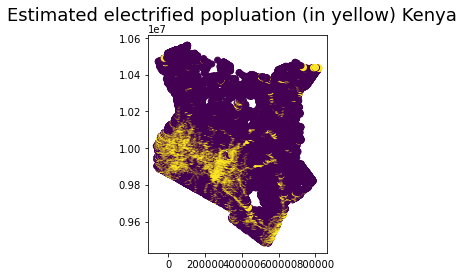

In [9]:
fig, ax = plt.subplots(1, 1)
point.plot(column='elec', ax=ax)
fig.suptitle('Estimated electrified popluation (in yellow) Kenya', fontsize=18)

## 6. Download Renewable.ninja data for all 378 cells
To run this code you need to have installed R on your computer and the package "curl". In addition you need to have a log in on renewables.ninja and get your API token to dowload a higher share of locations per day

Approx 24 h due to the max dowloads per hour

In [10]:
%load_ext autoreload
%autoreload
from renewable_ninja_download import *
from datetime import datetime
import os

#To be able to download you need to install the package curl from R and also have R installed on your computer
# Easiest is to write  install.packages("curl") where you have 

date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)
# add your token for API from your own log in on Renewable Ninjas
token = 'ed519952eff7850cece8c746347fee2d068ab988'
time_zone_offset = 3  # Kenya is UTC + 3hours to adjust for the time zone
shapefile = '../Projected_files/new_40x40points_WGSUMT37S.shp'
#Add the path to the RScript.exe under Program Files and add here
Rpath =  'C:\\Progra~1\\R\\R-4.1.2\\bin\\RScript.exe'
srcpath = os.getcwd()
print(srcpath)
path = "temp"
coordinates = project_vector(shapefile)
wind, solar = csv_make(coordinates)
down = download(path, Rpath, srcpath, wind, solar, token)
adjust_timezone(path, time_zone_offset)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022 01 12-12:51:32_PM
C:\Users\sebas\Desktop\GEOSeMOSYS_Kenya-master (2)\GEOSeMOSYS_Kenya-master\src
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets


## 7. Scale down from1x1 km to 40 x 40 km electrified and unelectrified demand cells and save to un_elec/elec.csv and demand_cells.csv

From the demand_cell.csv file identify the cells that does not have any electrified cells in the 40x40 cell and classify them as unelectrified. 

Approx. 5 min

In [12]:
%load_ext autoreload
%autoreload
from datetime import datetime

date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)
#Make sure you are in the /src directory when you start this script
print(os.getcwd())

from post_elec_GIS_functions import *
shape = '../Projected_files/Final_Polygons_Kenya.shp'
gdp = '../Projected_files/masked_UMT37S_GDP_PPP_2015_WGS_84.tif'
elec_shp = '../Projected_files/elec.shp'
demandcells = os.path.join(os.getcwd(), 'run/Demand/demand_cells.csv')

join(elec_shp, gdp, shape)
elec(demandcells)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022 01 13-09:16:54_AM
C:\Users\sebas\Desktop\GEOSeMOSYS_Kenya-master (2)\GEOSeMOSYS_Kenya-master\src
epsg:32737
EPSG:32737
masked_UMT37S_GDP_PPP_2015_WGS_84


C:\Users\sebas\Desktop\GEOSeMOSYS_Kenya-master (2)\GEOSeMOSYS_Kenya-master\src\post_elec_GIS_functions.py:45: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  demand_cells.to_file(os.path.join(os.getcwd(), 'run\Demand\demand.shp'))


## 8. Calculate the demand per cell based on following equations (MANUAL STEP in Excel)

file name: demand_cells.xlsx

The demand files are already in the repository and are not needed to be recalculated for the scenarios

![title](input_data/eq1.png)
![title](input_data/eq2.jpg)

(In Excel)
The reference scenario follows the reference scenario from [Updated least cost power development plan 2020-2040 (LCPDP 2020-2040)](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf) but deducts the un-electrified scenario which is multiplied with the [estimated demand from LCPDP 2020-2040 at 78 kWh/connection and annual growth of 4%](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf) and [4 people per household](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf). Full electrification is achived by 2030 following the SDG7 agenda 2030.

The vision scenario follows the vision scenario from [LCPDP 2020-2040](http://gak.co.ke/wp-content/uploads/2019/02/Updated-Least-Cost-Power-Development-Plan-2017-2022-min.pdf) but deducts the un-electrified scenario which is multiplied with the rural demand at [118 kWh/connection (LCDP 2020-2040) and annual growth of 6%](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf) and [4 people per household](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf). Full electrification is achieved 2030 according to the plans in [LCPDP 2020-2040](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf). Even though there is expected increase in population growth rate the un-electrified population was kept at the 2018 level (12.8 million un-electrified) as the growing population will be part of the overall demand from the Updated least cost power development plan, and also included in an electrified or un-electrified household.

The demand after fully electrified (2030) is also assumed to increase with an annual growth rate of 4% and 6% respectively for all unelectrified households[LCPDP 2020-2040](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf).



# 9. Distribution lines - Pathfinder



## 9.1 Identify the 40x40 km cells that has no HV line

In [13]:
%load_ext autoreload
%autoreload
import os
from datetime import datetime
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")

#Identify unelectrified polygons

from Build_csv_files import *
polygons_all = '../Projected_files/Final_Polygons_Kenya.shp'
noHV = 'run/noHV_cells.csv'
shape =  "run/Demand/un_elec_polygons.shp"

noHV_polygons(polygons_all, noHV, shape)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\sebas\Desktop\GEOSeMOSYS_Kenya-master (2)\GEOSeMOSYS_Kenya-master\src\Build_csv_files.py:400: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  unelec_shp = gpd.GeoDataFrame(crs=32737)


## Manual step in ArcMap
- Split by attribute "Projected_files/Final_polygons_Kenya.shp" in attribute pointid to src/temp folder

This is dowloaded from Zenodo and not needed to execute.

In [14]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

from Download_files import *
import os
#Make sure you are in the /src directory when you start this script
print(os.getcwd())

download_url_data("input_data/dijkstra.txt","src/temp")
unzip_all('input_data/dijkstra.txt', 'temp')

2022 01 13-09:21:44_AM
C:\Users\sebas\Desktop\GEOSeMOSYS_Kenya-master (2)\GEOSeMOSYS_Kenya-master\src


()

## 9.2 Run Pathfinder for all of Kenya
- Build target.csv and weights.csv from unelectrified population per 1x1 km cell with a population over x and roadnetwork to weight 0.5 and where there is grid weight 0.01.
- Define the origin (center of the cell) and run the many-to-many Dijkstra [Pathfinder algorithm](https://github.com/facebookresearch/many-to-many-dijkstra) (Rohrer, 2019)
- The path where there is an overlap with grid is removed and the remainder is concidered the new distribution lines.
- The lenght of the path is summed to km and the length of the LV per cell is then multiplied with the cost per MW-km. [The cost per km is set to 4000 USD/MW-km and 15 000 USD/MW for a substation](https://iea-etsap.org/E-TechDS/PDF/E12_el-t&d_KV_Apr2014_GSOK.pdf).

In [16]:
%autoreload
from datetime import datetime
import os
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")

from Pathfinder_processing_steps import *
path = '../Projected_files/'
proj_path = 'temp'
elec_shp = '../Projected_files/elec.shp'


pathfinder_main(path,proj_path, elec_shp)

Calculating Pathfinder for each cell, used for the OSeMOSYS-file
Make raster of pathfinder
Pathfinder is now mosaicked to pathfinder.tif
Remove pathfinder where grid is passed to not double count
Calculating Pathfinder for each cell, used for the OSeMOSYS-file
Make raster of pathfinder
Pathfinder is now mosaicked to pathfinder.tif
Remove pathfinder where grid is passed to not double count


## 10. Near table for all unelectrified cells (MANUAL STEP)

* In ArcMap Near ............within the distance 50 000 m.
* It is a simplification as it does not calculate the exact distance from the grid ut instead from the central point of the electrified cell.

## 10. Build the following csv files for building the data file to OSeMOSYS
- GIS_data.csv
- capacityfactor_solar.csv
- capacityfactor_wind.csv
- capitalcost.csv
- inputactivity.csv
- outputactivity.csv
- capacitytoactivity.csv

It also generates a technology and fuel file that is convenient to paste into the base OSeMOSYS txt file for the SETs TECHNOLOGY and FUEL.

## Transmission lines distance and presence of minigrid
The cells that has at least one electrified cell and are not situated 5000 m from a minigrid are concidered electrified by transmission lines.

Cost concidered are [2500 USD MW-km for transmission lines and 1500 USD/MW](https://iea-etsap.org/E-TechDS/PDF/E12_el-t&d_KV_Apr2014_GSOK.pdf) for substation and  [4000 USD/MW-km](https://iea-etsap.org/E-TechDS/PDF/E12_el-t&d_KV_Apr2014_GSOK.pdf) for low voltage lines.

The fixed cost of HV/LV transmission lines are set to 2.5% of the capital cost [Updated-Least-Cost-Power-Development-Plan-2017-2022](http://gak.co.ke/wp-content/uploads/2019/02/Updated-Least-Cost-Power-Development-Plan-2017-2022-min.pdf)



In [23]:
%load_ext autoreload
%autoreload
from datetime import datetime
import os
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")

print(date)

from Build_csv_files import * 

renewable_path = 'temp'
pop_shp = 'new_40x40points_WGSUMT37S.shp'
unelec = 'run/un_elec.csv'
noHV = 'run/noHV_cells.csv'
HV = 'run/HV_cells.csv'
elec = 'run/elec.csv'
Projected_files_path = '../Projected_files/'
distribution_network = 'run/Demand/distributionlines.csv'
distribution_length_cell = 'run/Demand/Distribution_network.xlsx'

capital_cost_HV = 2.5 #kUSD MW-km
substation = 1.5 #kUSD/MW
capital_cost_LV = 4 #kUSD/MW
capital_cost_LV_strengthening = 1 #kUSD/MW Assumed 25% of the cost
capacitytoactivity = 31.536 #coversion MW to TJ
distribution_cost = '0'
path = 'run/ref'
neartable = 'run/Demand/Near_table.csv'

#Solar and wind csv files
renewableninja(renewable_path, path)
#Location file
GIS_file(path)
matrix = adjacency_matrix(neartable, noHV, HV, path)

#calculates the shortest distance to the HV line from the center of the 40x40 cells
#transmission_near = "run/Demand/transmission.shp"
#transmission_near = near_dist(pop_shp, noHV, Projected_files_path)
capital_cost_transmission_distrib(capital_cost_LV_strengthening, distribution_network, elec, noHV, HV, unelec, capital_cost_HV, substation, capital_cost_LV, capacitytoactivity, distribution_cost, path, distribution_length_cell, matrix)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022 01 13-09:52:25_AM


# 12. Update the final files that are not updated by the script (MANUAL step)

These files are automatically dowloaded for the required runs.

- Demandprofile.csv (KPLC, 2015 halfhourly profile)
- demandprofile_rural.csv [Williams et al., 2018](https://ieeexplore.ieee.org/document/8521099/)
- emissions.csv
- capitalcost_RET_ref.csv [NREL - moderate](https://atb.nrel.gov/)
- capitalcost_RET_vision.csv [NREL -  advanced](https://atb.nrel.gov/)
- Merge fixedcost_tnd to fixed_cost [NREL - moderate/advanced](https://atb.nrel.gov/)
- variable_cost.csv
- Operational_life.csv [NREL - moderate/advanced](https://atb.nrel.gov/)
- battery [NREL - moderate/advanced](https://atb.nrel.gov/)

# 14. Run the [GEOSeMOSYS code](https://github.com/KTH-dESA/GEOSeMOSYS) by Moksnes et al. (2020) through the command line
To fit the Kenya analysis the code is modified with the following additions:
- Electrified cells are treated separatley therefore an extra row is added to the functions where Solar PV, LV lines, or final electricity is calculated. They are treated as a separate cell with the extension of "_0" and "_1" for un-electrified and electrified

# 14 a) Reference scenario
Approx 3 h

In [29]:
%load_ext autoreload
%autoreload
from datetime import datetime
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)


!python run/run_datafile_ref.py run/ref run/Kenya_basefile_reference.txt run/output/REF.txt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022 01 14-07:05:20_AM
Operational life 2022-01-14 07:05:22
Fixed cost 2022-01-14 07:05:22
No total_annual_technology_limit file
SpecifiedAnnualDemand 2022-01-14 07:05:24
Capital cost dynamic cost 2022-01-14 07:05:26
Capital cost 2022-01-14 07:07:28
Capacity to activity 2022-01-14 07:07:28
SpecifiedDemandProfile 2022-01-14 07:07:29
Emission activity 2022-01-14 07:09:05
Variable cost 2022-01-14 07:09:06
Input activity 2022-01-14 07:09:06
Adjacency matrix 2022-01-14 07:09:07
Outputactivity 2022-01-14 07:09:07
Capacity factor 2022-01-14 07:09:10
write to file 2022-01-14 07:59:46


# 14 b) Vision 2030 scenario
Approx 3h

In [30]:
%autoreload
from datetime import datetime
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

!python run/run_datafile_vision.py run/vision/update run/Vision.txt run/output/Vision.txt

2022 01 14-07:59:48_AM


Traceback (most recent call last):
  File "run/run_datafile_vision.py", line 68, in <module>
    run(sys.argv[1:])
  File "run/run_datafile_vision.py", line 60, in run
    dict_df = load_csvs(args.data_path)
  File "C:\Users\sebas\Desktop\GEOSeMOSYS_Kenya-master (2)\GEOSeMOSYS_Kenya-master\src\run\build_data_file_vision.py", line 20, in load_csvs
    filepaths = [f for f in listdir(paths) if isfile(join(paths, f))]
FileNotFoundError: [WinError 3] The system cannot find the path specified: 'run/vision/update'


# 14 c) Vision 2030 scenario dry hydro (can be rewritten to just replace the capacityfactors from Vision scenario)
Approx 3h

In [ ]:
%autoreload
from datetime import datetime
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

!python run/run_datafile_vision.py run/vision/update run/Dry_Vision.txt run/output/Dry_Vision.txt

## 15. Reduce the datafile with [pre_processing](https://github.com/OSeMOSYS/OSeMOSYS_GNU_MathProg/blob/e62db90d7304810050e623eac2bc2d144b868ae1/scripts/preprocess_data.py) script to reduce time to build lp matrix

In [ ]:
import os
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

os.chdir('run/output')

!python pre_processing.py otoole REF_pre.txt REF.txt
!python pre_processing.py otoole Vision_pre.txt Vision.txt
!python pre_processing.py otoole Dry_Vision_pre.txt Dry_Vision.txt

# 15) Check the datafile before the run
The datafile can have Nan so those needs to be deleted as they cannot be processed in GNUMath Prog.

# 16) Run the data file on a High performance cluster
- This analysis was run on the KTH PDC resource Tegner with the performance of 2 x 12 cores Intel E5-2690v3 Haswell, 512 GB RAM 24 cores and 1  x NVIDIA Quadro K420. 

sbatch run_cplex_tegner_REF.sh

sbatch run_cplex_tegner_Vision.sh

sbatch run_cplex_tegner_DryHydro.sh

## 16) Extract dual values from the .sol file

In [ ]:
!python .\OSeMOSYS_CPLEX_dual_values.py run/output/REF.sol results/Kenya_REF_dual.txt
!python .\OSeMOSYS_CPLEX_dual_values.py run/output/Vision.sol results/Kenya_Vision_dual.txt
!python .\OSeMOSYS_CPLEX_dual_values.py run/output/Dry_Vision.sol results/Kenya_Dry_Vision_dual.txt

## 17) Results extraction
### To csv and pandas dataframes

In [ ]:
#%load_ext autoreload
%autoreload

from datetime import datetime
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")

from Results_extraction import read_data
import os

ref = read_data('results/REF_solved.txt')
vision = read_data('results/Vision_solved.txt')
dry_vision = read_data('results/Dry_vision_solved.txt')

prod_ref = ref['ProductionByTechnologyAnnual']
prod_vision = vision['ProductionByTechnologyAnnual']
prod_dry_vision = dry_vision['ProductionByTechnologyAnnual']

new_cap_ref = ref['NewCapacity']
new_cap_vision = vision['NewCapacity']
new_cap_dryvision = dry_vision['NewCapacity']

prod_ref.head(10)

### Make GIS files

In [ ]:
#%load_ext autoreload
%autoreload
import os
from datetime import datetime
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")

from Build_csv_files import *
#Create maps for the results



polygons_all = '../Projected_files/Final_Polygons_Kenya.shp'

BaseyearHV = 'run/HV.csv'
shapeHV = 'results/connected.shp'

connectedHV = 'results/connected_HV.csv'
shapeHV = 'results/connected.shp'

connectedHV_vision = 'results/connected_HV_vision.csv'
shapeHV_vision = 'results/connected_vision.shp'

connectedLV = 'results/connected_LV.csv'
shapeLV = 'results/connected_LV.shp'

connectedLV_vision = 'results/connected_LV_vision.csv'
shapeLV_vision = 'results/connected_LV_vision.shp'

distribution = 'results/electrified_distribution.csv'
shapedistribution = 'results/distribution.shp'

wind = 'results/wind.csv'
shapewind = 'results/wind_cells.shp'

wind_vision = 'results/wind_vision.csv'
shapewind_vision = 'results/wind_cells_vision.shp'

noHV_polygons(polygons_all, connectedHV, shapeHV)
noHV_polygons(polygons_all, connectedLV, shapeLV)
noHV_polygons(polygons_all, distribution, shapedistribution)
noHV_polygons(polygons_all, wind, shapewind)

noHV_polygons(polygons_all, connectedHV_vision, shapeHV_vision)
noHV_polygons(polygons_all, connectedLV_vision, shapeLV_vision)
noHV_polygons(polygons_all, wind_vision, shapewind_vision)

### Clustering analysis of the dual values based on the production technology

In [ ]:
%load_ext autoreload
%autoreload
from datetime import datetime
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
import matplotlib
matplotlib.use('Qt5Agg')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from Results_extraction import clustering, normalize
from sklearn import mixture
sns.set_context("notebook",rc={"font.size": 18})
sns.set_style("whitegrid")

datafile = pd.read_csv("results/cluster_dual.csv", index_col=0)

cols = ['Max of 2025 dual value', 'Max of 2031 dual value','Sum of 2025 demand','Un-elec in base year', 'TRHV new connection', 'Sum of 2031 demand']

normalized_data = normalize(datafile)
data_for_clustering = np.array(normalized_data)

n_clusters = 3

df = clustering(n_clusters,data_for_clustering,cols[0],cols[1],cols[2], cols[3],cols[4],cols[5])

df


### Plot of clusters

In [ ]:
mycolors = ["grey","red","green","blue"]
for (i,subdf) in df.groupby("class"):

    plt.scatter(subdf['Max of 2031 dual value'],subdf['Sum of 2031 demand'],label="Cluster {}".format(i),c=mycolors[i-1])

plt.legend()
plt.xlabel('Max of 2025 dual value')
plt.ylabel('Sum of 2025 demand')
plt.savefig("clusters.png")
